<a href="https://colab.research.google.com/github/husseinfawaz20/QoT/blob/main/QoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import absolute
from numpy import sqrt
import xgboost as xgb
import time
from sklearn.feature_selection import SelectFromModel

!pip install shap

import shap
import shap.plots
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.4 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#**Read Dataset +  Train/Test**

In [4]:
df = pd.read_csv('DS_LPLevel_10100_Het_CFEGN_v3.csv')
target = 'Lightpath GSNR'
# df.head()
# df.describe()
# df.info()
# df.shape

In [5]:
X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_data_points = df.shape[0]
num_features = X.shape[1]

In [6]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

#**Util Functions**

In [7]:
def saveResults(y_test,y_pred,index,nb_features,tt,it):
  r2 = float(format((r2_score(y_test,y_pred)),'.3f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
  mae = float(format((mean_absolute_error(y_test , y_pred)),'.3f'))

  average_it,max_it,min_it = it;
  average_it=format(average_it,'.3f')
  max_it=format(max_it,'.3f')
  min_it=format(min_it,'.3f')

  dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time (s)':[tt],'average inference time/data point (ms)':[average_it],'max inference time/data point (ms)':[max_it],'min inference time/data point (ms)':[min_it]})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')

In [72]:
def addResults(rmse,mae,r2,index,nb_features,tt,it):
  if len(it) == 3:
      avg,max,min = it
      dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time':[tt],'average inference time/data point':[avg],'max inference time/data point':[max],'min inference time/data point':[min]})
  else:
    dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time':[tt],'average inference time/data point':[it],'max inference time/data point':['-'],'min inference time/data point':['-']})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')

In [9]:
def get_results():
  data = pd.read_csv('results.csv')
  return data.iloc[:,-9:]

In [10]:
def train_selected_features(selected_features,fs,model='xgb'):
  X_train_selected = X_train[selected_features]
  if model=='linear_regression':
      model_selected = LinearRegression()
  else:
    model_selected = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)
  nb_features = len(selected_features)
  save_features(fs,selected_features)

  start_time = time.time()
  model_selected.fit(X_train_selected, y_train)
  end_time = time.time()

  training_time = end_time - start_time
  inference_time_per_data_point = calc_inference_time(model_selected,data_points=X[selected_features].to_numpy())

  X_test_selected = X_test[selected_features]
  y_pred =  model_selected.predict(X_test_selected)

  saveResults(y_test,y_pred,f'Feature Selection method: {fs}',nb_features,training_time,inference_time_per_data_point)
  return get_results()

In [11]:
def get_features():
  data = pd.read_csv('selected_features.csv')
  return data.iloc[:,-3:]

In [12]:
import csv

output_file_path = 'selected_features.csv'

def save_features(feature_selection_types,selected_features):
  file_exists = os.path.exists(output_file_path)
  with open(output_file_path, mode='a', newline='') as file:
      writer = csv.writer(file)
      if not file_exists:
          writer.writerow(['Feature_Selection_Method','Nb_Features', 'Selected_Features'])
      for idx, selected_feature_list in enumerate([selected_features]):
          method_name = feature_selection_types
          nb_features = len(selected_features)
          selected_features_str = ', '.join(selected_feature_list)
          writer.writerow([method_name, nb_features,selected_features_str])

In [13]:
def calc_inference_time(model,data_points=X.to_numpy(),flag=0.0): #flag=0 means already performed .fit so gives avg,max,min else gives avg only
  if flag==0.0 :
    inference_times = []
    for data_point in data_points:
        start_time = time.time()
        prediction = model.predict(data_point.reshape(1, -1))
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000   # Convert to milliseconds
        inference_times.append(inference_time)

    average_inference_time = np.mean(inference_times)
    max_inference_time = np.max(inference_times)
    min_inference_time = np.min(inference_times)
    return average_inference_time,max_inference_time, min_inference_time
  else:
      return flag/num_data_points

#**Data Visualization**

<Axes: >

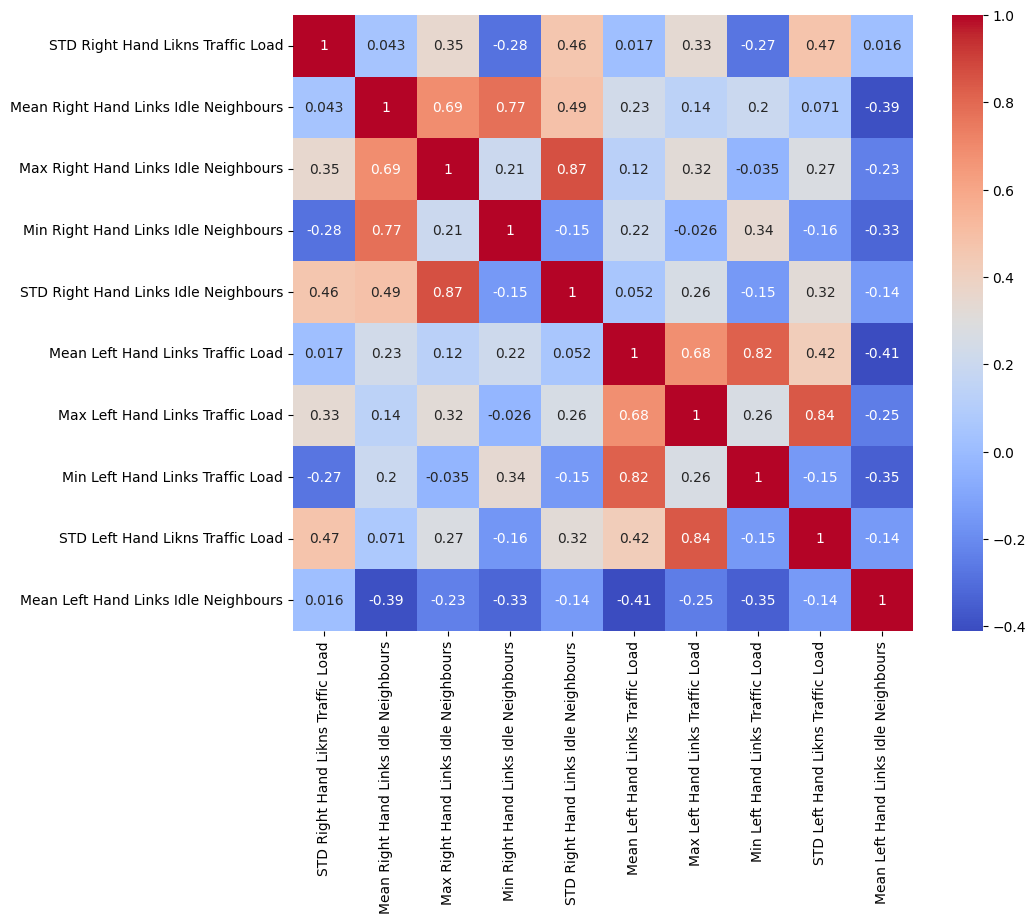

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.iloc[:, 34:44].corr()
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
#             cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
sns.heatmap(corr, annot=True, cmap='coolwarm')


array([[<Axes: title={'center': 'Lightpath Span Number'}>,
        <Axes: title={'center': 'Mean Right Hand Links Traffic Load'}>],
       [<Axes: title={'center': 'Root Mean Square Link Powers'}>,
        <Axes: title={'center': 'Mean Left Hand Links Idle Neighbours'}>]],
      dtype=object)

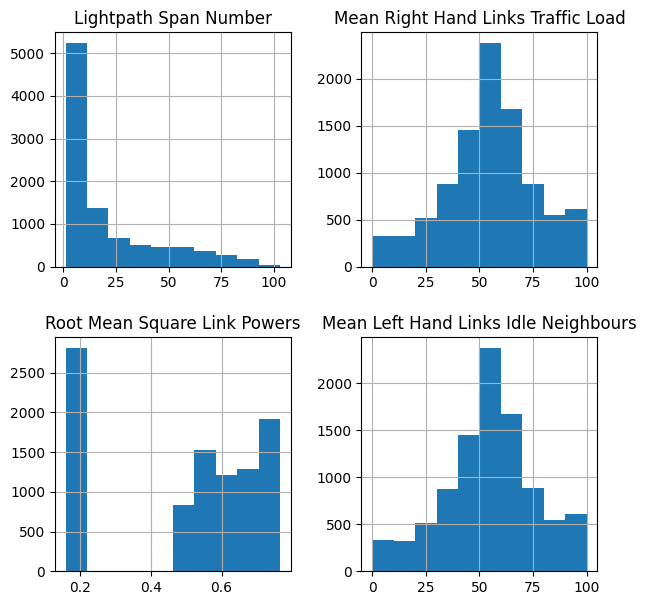

In [ ]:
f1=df[['Modulation Format Level',	'Max Spans Lengths','Lightpath Lengths', 'Link Number']]
f2=df[['Lightpath Span Number','Mean Right Hand Links Traffic Load','Root Mean Square Link Powers','Mean Left Hand Links Idle Neighbours']]

# f1.hist(figsize = (7,7))
f2.hist(figsize = (7,7))

# feature= 'Modulation Format Level'
# target = 'Lightpath GSNR'

# plt.xlabel(feature)
# plt.ylabel(target)

#Scatter Plot:
# plt.scatter(df[feature], df[target])
# plt.title('Scatter Plot of STD Right Hand Links Idle Neighbours and Max Right Hand Links Idle Neighbours')

# # Pairwise Scatter Plot:
# sns.pairplot(df[['Modulation Format Level',	'Max Spans Lengths' ,target]])

# Regression Line Plot:
# sns.regplot(data=df, x=feature, y=target)
# plt.title('Regression Line Plot of Modulation Format Level vs Lightpath GSNR')

# #Histograms and Density Plots:
# plt.hist(df[feature], bins=20)
# plt.title('Histogram of Feature1')

# Correlation Heatmap:
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')


In [ ]:
correlation_matrix = X.corrwith(y)

# Sort the features based on their absolute correlation values
sorted_features = correlation_matrix.abs().sort_values(ascending=False)

# Print the top correlated features and their correlation values
print(sorted_features.head(10))

Modulation Format Level     0.963502
Max Links Lengths           0.916959
Max Span Number per Link    0.899671
Lightpath Lengths           0.835398
Max Spans Lengths           0.833392
Lightpath Span Number       0.831201
Min Link Powers             0.816710
Link Number                 0.796725
STD Links Lengths           0.738621
STD Span Number per Link    0.731092
dtype: float64


# **Regression Models**

##**XGB Regressor**

In [ ]:
xgb = XGBRegressor()

start_time = time.time()
xgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb)

y_pred = xgb.predict(X_test)
saveResults(y_test,y_pred,"XGB",X.shape[1],training_time,inference_time_per_data_point)

**XGB with hyperparameter tuning 3 parameters**

In [14]:
xgb = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)

start_time = time.time()
xgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb)

y_pred = xgb.predict(X_test)
saveResults(y_test,y_pred,"XGB after tuning",X.shape[1],training_time,inference_time_per_data_point)

**XGB with CV=5 + hyperparameter tuning**

In [ ]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
xgb_cv = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)

start_time = time.time()
scores = cross_validate(xgb_cv, X_train, y_train, cv=cv,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb_cv,flag=training_time)

rmse = sqrt(mean(absolute(scores['test_neg_mean_squared_error'])))
mae= mean(absolute(scores['test_neg_mean_absolute_error']))
r2= mean(absolute(scores['test_r2']))

addResults(rmse,mae,r2,"XGB with CV=5 + tuning ",X.shape[1],training_time,inference_time_per_data_point)

##**XGB Regressor with Grid Search and CV=5**

In [ ]:
xgb = XGBRegressor()
cv = KFold(n_splits=5, random_state=42, shuffle=True)

#LPLevel Dataset Params
params = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.03,0.05,0.1], #0.1
              # 'max_depth': [4],
              # 'min_child_weight': [1],
              'subsample': [0.3,0.5,0.7], #0.3
              # 'colsample_bytree': [0.3],
              'n_estimators': [100,300,500], #500
              }

grid_search = GridSearchCV(xgb, params, cv=cv,scoring = 'r2')

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_reg = grid_search.best_estimator_

y_pred = best_reg.predict(X_test)
saveResults(y_test,y_pred,"XGB with GridSearch CV=10",X.shape[1],training_time,inference_time_per_data_point)

##**XGB** tuning the params not using GridSearch

In [ ]:
grid = pd.DataFrame({'eta':[0.01,0.03,0.05,0.1,0.15,0.2,0.3,0.4],
'subsample':np.repeat([0.1,0.3,0.4,0.5],2)})

def fit(x):
    params = {'objective':'reg:squarederror',
              'eval_metric':'mae',
              'eta':x[0],
              'subsample':x[1]}
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params,
    nfold=5,
    num_boost_round=100, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)

    return xgb_cv[-1:].values[0]

grid[['train-rmse-mean','train-rmse-std',
'test-rmse-mean','test-rmse-std']] = grid.apply(fit,axis=1,result_type='expand')
grid


##**Other ML Regressor Models**

###**Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 42)
start_time = time.time()
dt.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(dt)

y_pred = dt.predict(X_test)
saveResults(y_test,y_pred,"Decision Tree",X.shape[1],training_time,inference_time_per_data_point)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
k=5
dt = DecisionTreeRegressor(random_state = 42)
cv = KFold(n_splits=k, random_state=42, shuffle=True)

start_time = time.time()
scores = cross_validate(dt, X_train, y_train, cv=cv,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
end_time = time.time()

training_time = end_time - start_time

rmse = sqrt(mean(absolute(scores['test_neg_mean_squared_error'])))
mae= mean(absolute(scores['test_neg_mean_absolute_error']))
r2= mean(absolute(scores['test_r2']))

inference_time_per_data_point = calc_inference_time(dt,flag=training_time)
addResults(rmse,mae,r2,f'Decision Tree with CV={k}',X.shape[1],training_time,inference_time_per_data_point)

###**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor()

start_time = time.time()
rfc.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(rfc)

y_pred = rfc.predict(X_test)

saveResults(y_test,y_pred,"Random Forest",X.shape[1],training_time,inference_time_per_data_point)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
k=5
rfc = RandomForestRegressor()
cv = KFold(n_splits=k, random_state=42, shuffle=True)

start_time = time.time()
scores = cross_validate(rfc, X_train, y_train, cv=cv,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
end_time = time.time()

training_time = end_time - start_time
rmse = sqrt(mean(absolute(scores['test_neg_mean_squared_error'])))
mae= mean(absolute(scores['test_neg_mean_absolute_error']))
r2= mean(absolute(scores['test_r2']))

inference_time_per_data_point = calc_inference_time(rfc,flag=training_time)
addResults(rmse,mae,r2,f'Random Forest with CV={k}',X.shape[1],training_time,inference_time_per_data_point)

###**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

start_time = time.time()
lr.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(lr)

y_pred = lr.predict(X_test)
saveResults(y_test,y_pred,"Linear Regression",X.shape[1],training_time,inference_time_per_data_point)

<Axes: >

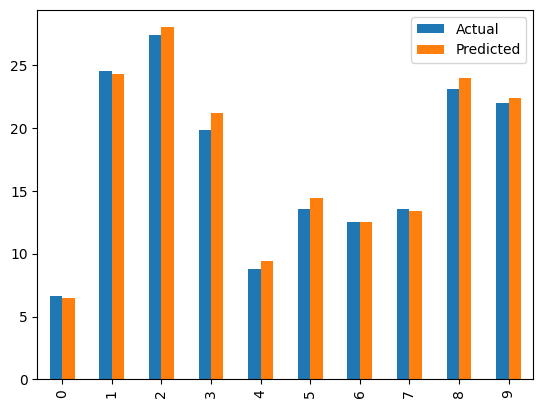

In [ ]:
evaluate = pd.DataFrame({"Actual": y_test.values.flatten(), "Predicted": y_pred.flatten()})
evaluate.head(10)
evaluate.head(10).plot(kind = 'bar')

In [ ]:
selected_features = ['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths',
       'STD Spans Lengths', 'Min Spans Lengths',  'Ligthpath Total Traffic Load',
       'Mean Links Lengths', 'Max Links Lengths', 'Lightpath Lengths',]
                    #  'Left Hand Lihthpath Traffic Load'
                    #  'Root Mean Square Link Powers', 'Right Hand Lihthpath Traffic Load']

train_selected_features(selected_features,'Linear Regression',model='linear_regression' )

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,Linear Regression,0.641,0.478,0.989,47,0.015027,0.055,1.052,0.042
1,Feature Selection method: Linear Regression FS,0.832,0.642,0.982,12,0.006560,0.054,4.059,0.041
2,Feature Selection method: Linear Regression FS,0.844,0.645,0.981,10,0.012180,0.052,0.663,0.041
3,Feature Selection method: Linear Regression,0.843,0.645,0.981,9,0.013898,0.065,9.135,0.042


##**DNN Model**

###**Sequential Model**

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6144      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 171,009
Trainable params: 171,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/500
230/240 [===========================>..] - ETA: 0s - loss: 1.9983 - mean_absolute_error: 1.9983
Epoch 1: val_loss improved from inf to 0.53904, saving model to Weights-001--0.53904.hdf5
240/240 [==============================] - 3s 7ms/step - loss: 1.9416 - mean_absolute_error: 1.9416 - val_loss: 0.5390 - val_mean_absolute_error: 0.5390
Epoch 2/500
233/240 [============================>.] - ETA: 0s - loss: 0.5656 - mean_absolute_error: 0.5656
Epoch 2: val_loss improved from 0.53904 to 0.51939, saving model to Weights-002--0.51939.hdf5
240/240 [==============================] - 1s 6ms/step - loss: 0.5615 - mean_absolute_error: 0.5615 - val_loss: 0.5194 - val_mean_absolute_error: 0.5194
Epoch 3/500
231/240 [===========================>..] - ETA: 0s - loss: 0.5645 - mean_absolute_error: 0.5645
Epoch 3: val_loss improved from 0.51939 to 0.48987, saving model to Weights-003--0.48987.hdf5
240/240 [==============================] - 1s 5ms/step - loss: 0.5618 - mean_absolute_error:

In [ ]:
wights_file = 'Weights-155--0.21131.hdf5' # choose the best checkpoint
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

y_pred = NN_model.predict(X_test)
saveResults(y_test,y_pred,"DNN")

60/60 [==============================] - 0s 2ms/step


###**DNN with Gridsearch CV=5**

In [ ]:
def create_model(optimizer = 'adam'):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return NN_model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_grid_dnn = {
    'epochs': [100],
     'batch_size': [128],
}
dnn_model = KerasRegressor(build_fn=create_model, verbose=0)

grid_search_dnn = GridSearchCV(estimator=dnn_model,
                               param_grid=param_grid_dnn,
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs=-1)
start_time = time.time()
grid_search_dnn.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
# inference_time_per_data_point = calc_inference_time(grid_search_dnn)

# Best DNN model and best hyperparameters
best_dnn_model = grid_search_dnn.best_estimator_
best_dnn_params = grid_search_dnn.best_params_

print("Best DNN Hyperparameters:", best_dnn_params)

y_pred = best_dnn_model.predict(X_test)

inference_time_per_data_point = (end_time - start_time) / num_data_points
saveResults(y_test,y_pred,"DNN with GridSearch",X.shape[1],training_time,'inference_time_per_data_point')

Best DNN Hyperparameters: {'batch_size': 128, 'epochs': 100}


###**MLP**

In [ ]:
from sklearn.neural_network import MLPRegressor

dnn_param_grid = {
    'hidden_layer_sizes': [ (300,)],  # Number of neurons in each hidden layer
    'activation': ['relu'],  # Activation function
    'learning_rate_init': [ 0.018],  # Initial learning rate,
  'learning_rate':  ['adaptive'],
     'batch_size': [128],
}
cv = KFold(n_splits=10, shuffle=True, random_state=42)
dnn_reg = MLPRegressor(random_state=42)

grid_search_dnn = GridSearchCV(dnn_reg, dnn_param_grid, cv=cv, scoring='neg_mean_squared_error')

start_time = time.time()
grid_search_dnn.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search_dnn)
best_dnn_model = grid_search_dnn.best_estimator_

y_pred_dnn = best_dnn_model.predict(X_test)

inference_time_per_data_point = (end_time - start_time) / num_data_points

saveResults(y_test,y_pred_dnn,"DNN with GridSearch CV=10",X.shape[1],training_time,inference_time_per_data_point)

## **EVALUATION**

In [ ]:
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,Linear Regression,0.641,0.478,0.989,47,0.083183,0.357,33.287,0.074


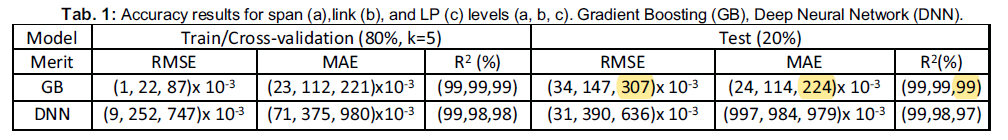

#**SHAP Explanations**

In [16]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_test)

###***Global Explanations show importance of each feature***

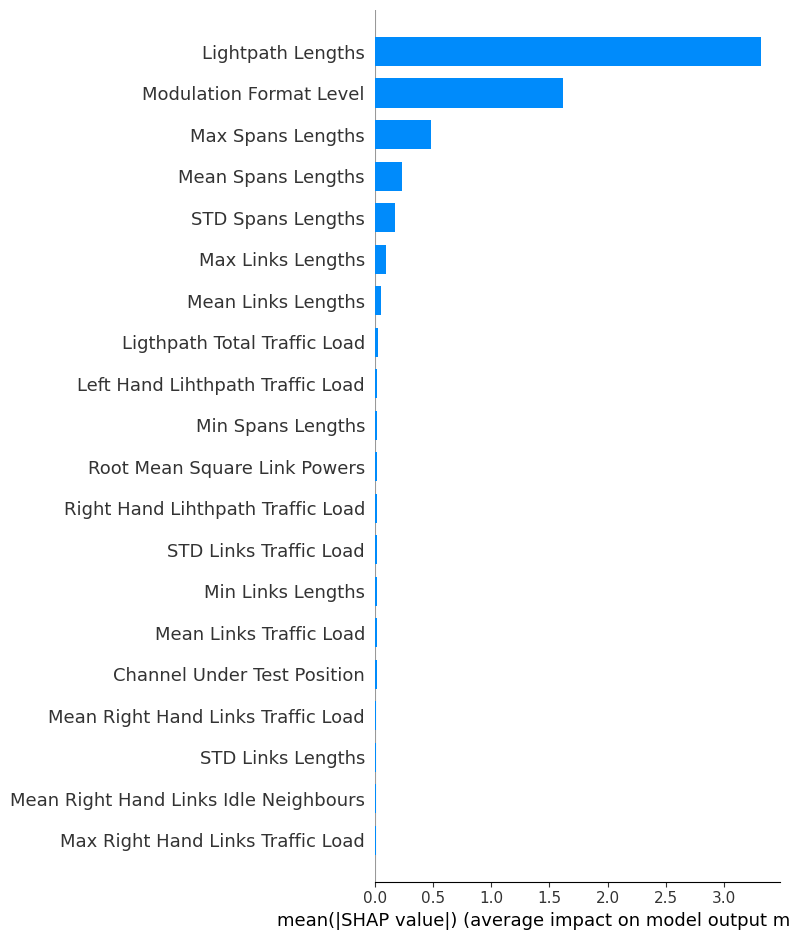

In [95]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

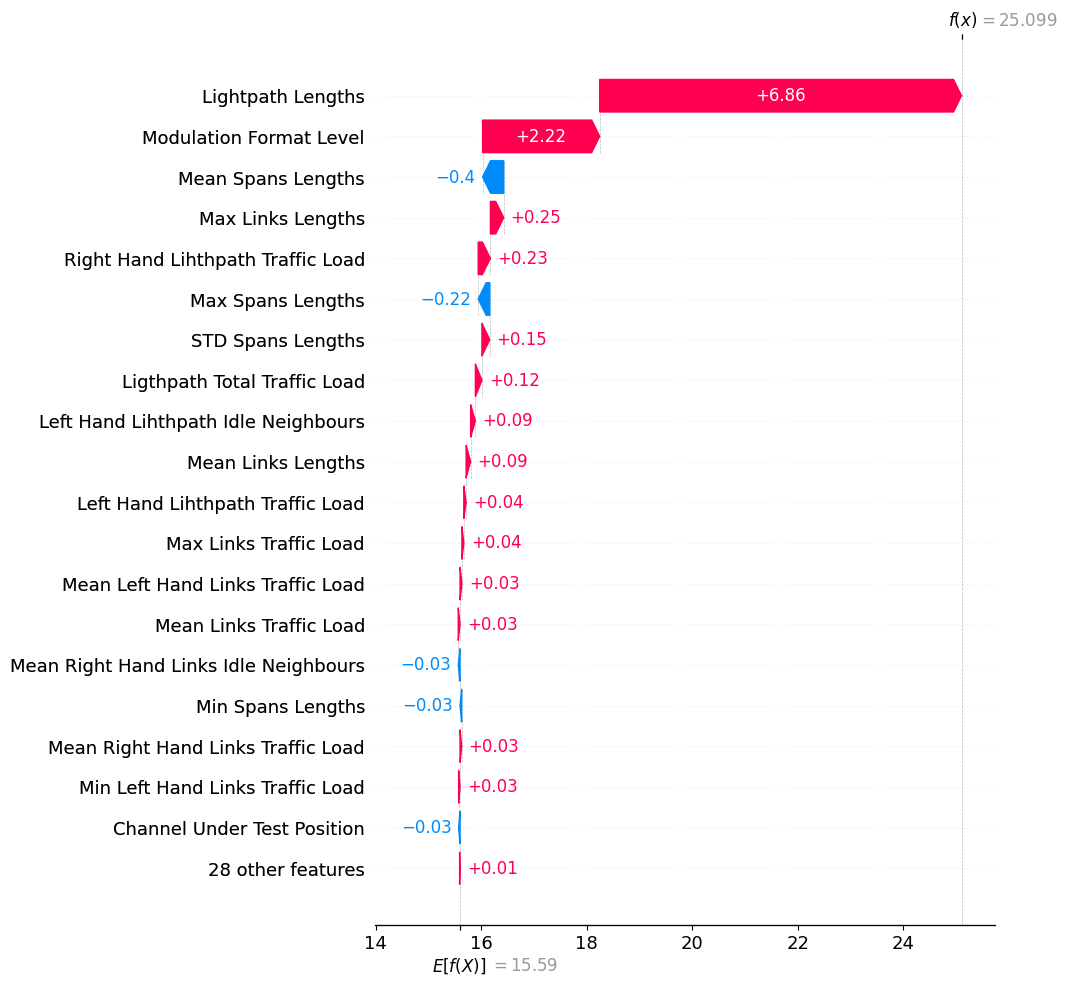

In [92]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1],feature_names=X_train.columns, base_values=xgb.predict(X_train).mean()), max_display=20)

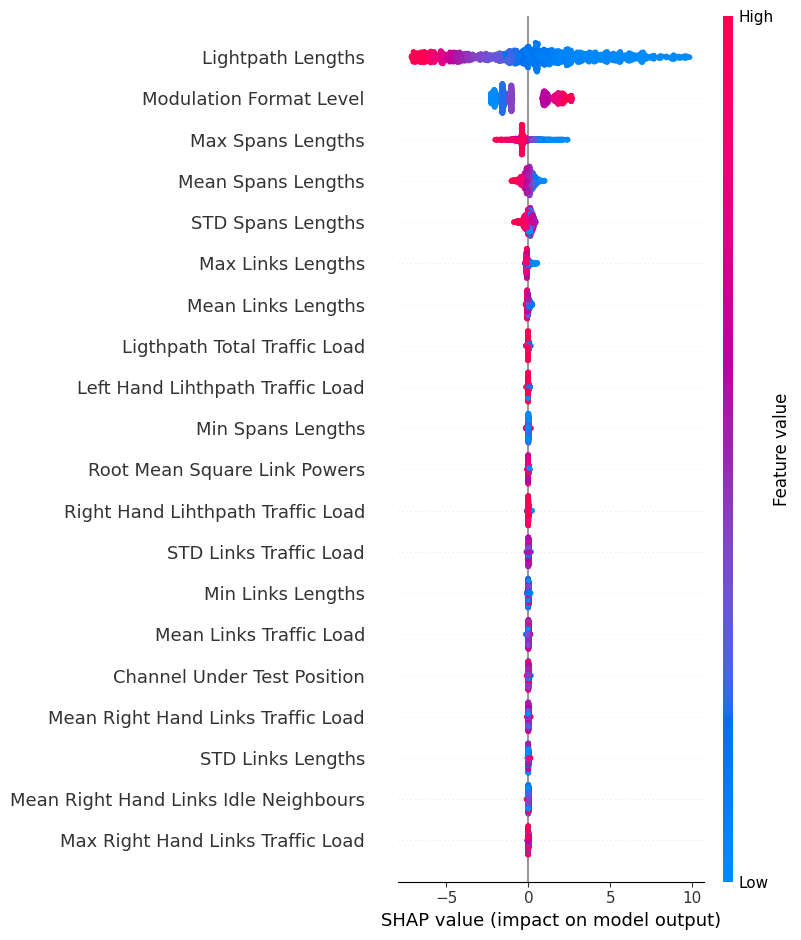

In [93]:
shap.summary_plot(shap_values, X_test)

# shap.dependence_plot("Lightpath Lengths", shap_values, X_test)
# shap.dependence_plot("Modulation Format Level", shap_values, X_test)
# shap.dependence_plot(("Lightpath Lengths","Modulation Format Level"), shap_interaction_values, X_test)
# shap.dependence_plot(("Max Links Lengths","Max Spans Lengths"), shap_interaction_values, X_test)


In [ ]:
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],matplotlib=True,show=False)
# shap.force_plot(explainer.expected_value, shap_values[0:500,:], X_test.iloc[0:500,:])
plt.savefig("shap_force_plot.jpg")

###***Local Shap Individual Predictions***

In [ ]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(xgb.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,Modulation Format Level,Link Number,Mean Spans Lengths,Max Spans Lengths,Min Spans Lengths,STD Spans Lengths,Ligthpath Total Traffic Load,Mean Links Traffic Load,Max Links Traffic Load,Min Links Traffic Load,...,STD Right Hand Links Idle Neighbours,Mean Left Hand Links Traffic Load,Max Left Hand Links Traffic Load,Min Left Hand Links Traffic Load,STD Left Hand Likns Traffic Load,Mean Left Hand Links Idle Neighbours,Max Left Hand Links Idle Neighbours,Min Left Hand Links Idle Neighbours,STD Left Hand Links Idle Neighbours,predict
7370,6,1,97.000,97,97,0.000,15.254,57.458,98.305,11.864,...,0.00000,16.00000,16,16,0.00000,11.765,11.765,11.765,0.000,24.900000
2189,5,1,104.000,104,104,0.000,47.458,55.847,83.051,11.864,...,0.00000,0.00000,0,0,0.00000,52.941,52.941,52.941,0.000,19.969999
6160,3,2,85.444,111,55,17.120,84.746,61.017,96.610,25.424,...,0.00000,1.50000,3,0,2.12130,47.727,77.273,18.182,41.784,13.100000
2907,5,1,62.600,87,51,15.758,37.288,49.068,100.000,13.559,...,0.00000,0.00000,0,0,0.00000,0.000,0.000,0.000,0.000,22.809999
2018,3,4,75.769,109,50,16.458,100.000,57.881,98.305,16.949,...,1.89300,0.75000,2,0,0.95743,71.429,100.000,42.857,26.082,15.340000
7063,1,12,84.179,117,51,19.856,100.000,58.559,100.000,23.729,...,0.28868,0.83333,7,0,2.03750,63.542,100.000,33.929,20.253,7.810000
346,3,2,88.455,120,64,19.881,49.153,48.220,98.305,20.339,...,4.94970,2.50000,4,1,2.12130,27.419,29.032,25.806,2.281,14.140000


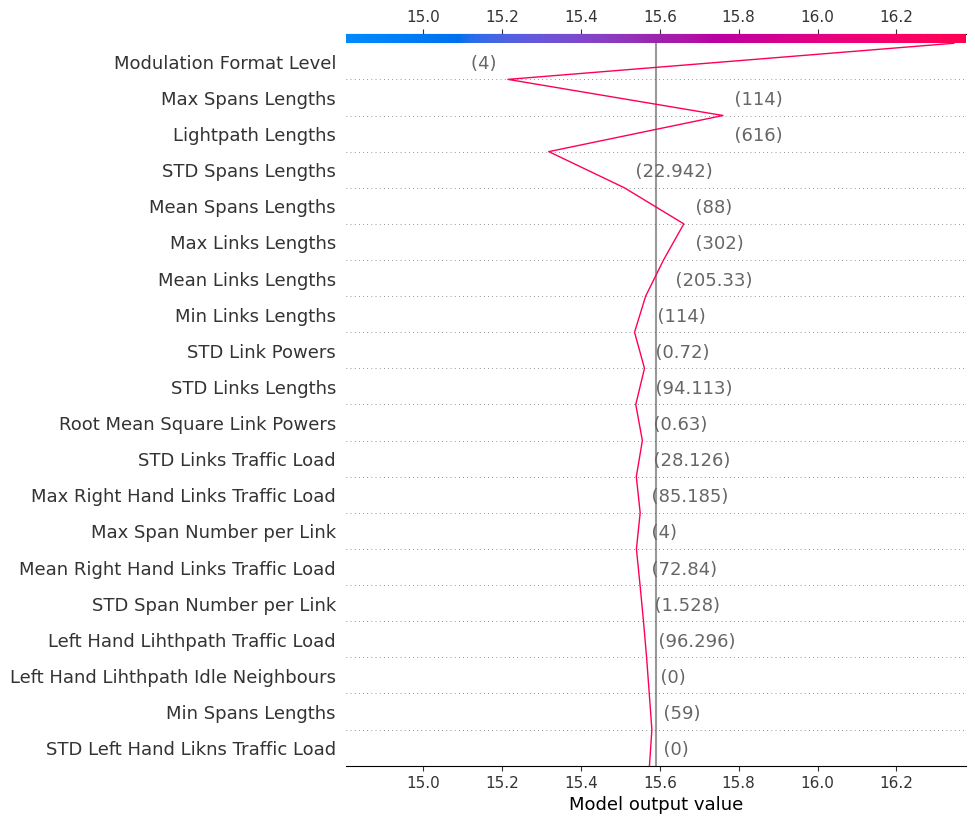

In [ ]:
shap.initjs()
i=209
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xgb)
    shap_values_Model = explainerModel.shap_values(X_test)
    # p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]],matplotlib=True,show=False)
    p= shap.decision_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]])
    return(p)

# avgValues = X_train.mean()
# print(avgValues)
shap_plot(i)
# plt.savefig(f'shap_force_plot_{i}.jpg')

#**Feature selection**

##**Method 1: Shaphypetune**

In [17]:
! pip install shap-hypetune
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7


In [ ]:
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
param_grid = {
    'n_estimators': 500,
    'learning_rate': [0.1],
    'subsample': [0.3],
}
xgb_model = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train, y_train, test_size=0.2, shuffle=True, random_state=33)
model = BoostSearch(xgb_model, param_grid=param_grid, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='mae', early_stopping_rounds=3, verbose=0)
y_pred =  model.predict(X_test)
saveResults(y_test,y_pred,"XGB with BoostSearch",'training_time','inference_time_per_data_point')
results()

In [18]:
X_regr_train, X_regr_valid, y_regr_train, y_regr_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

Boruta

In [20]:
model_boruta = BoostBoruta(xgb, max_iter=200, perc=100,importance_type='shap_importances', train_importance=False)
model_boruta.fit(X_regr_train, y_regr_train, eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='mae', early_stopping_rounds=6, verbose=0)

selected_features = (model_boruta.transform(X_regr_valid).columns) #to see which features

train_selected_features(selected_features,'Boruta')

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB after tuning,0.307,0.224,0.997,47,8.024816,0.585,28.939,0.399
1,Feature Selection method: Boruta,0.307,0.218,0.997,12,2.769405,0.582,28.985,0.396


RFE

In [21]:
model_rfe = BoostRFE(xgb, min_features_to_select=1, step=1,importance_type='shap_importances', train_importance=False)
model_rfe.fit(X_regr_train, y_regr_train, eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='rmse', early_stopping_rounds=6, verbose=0)

selected_features = (model_rfe.transform(X_regr_valid).columns) #to see which features
train_selected_features(selected_features,'RFE')

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB after tuning,0.307,0.224,0.997,47,8.024816,0.585,28.939,0.399
1,Feature Selection method: Boruta,0.307,0.218,0.997,12,2.769405,0.582,28.985,0.396
2,Feature Selection method: RFE,0.297,0.214,0.998,10,2.414373,0.587,33.825,0.400


RFA

In [22]:
from hyperopt import Trials

model_rfa = BoostRFA(xgb, min_features_to_select=1, step=1,importance_type='shap_importances', train_importance=False)
model_rfa.fit(X_regr_train, y_regr_train, trials=Trials(),eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='mae',early_stopping_rounds=6, verbose=0)

selected_features = (model_rfa.transform(X_regr_valid).columns) #to see which features
train_selected_features(selected_features,'RFA')

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB after tuning,0.307,0.224,0.997,47,8.024816,0.585,28.939,0.399
1,Feature Selection method: Boruta,0.307,0.218,0.997,12,2.769405,0.582,28.985,0.396
2,Feature Selection method: RFE,0.297,0.214,0.998,10,2.414373,0.587,33.825,0.400
3,Feature Selection method: RFA,0.289,0.210,0.998,31,5.079741,0.590,27.410,0.404


##**Method 2: Top K according to Shap Values**

In [26]:
feature_importance = np.abs(shap_values).mean(axis=0)

# Select top-k features
k = 9
top_k_indices = np.argsort(feature_importance)[-k:]
selected_features = X_train.columns[top_k_indices]

train_selected_features(selected_features,f'Top K={k}')

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB after tuning,0.307,0.224,0.997,47,8.024816,0.585,28.939,0.399
1,Feature Selection method: Boruta,0.307,0.218,0.997,12,2.769405,0.582,28.985,0.396
2,Feature Selection method: RFE,0.297,0.214,0.998,10,2.414373,0.587,33.825,0.400
3,Feature Selection method: RFA,0.289,0.210,0.998,31,5.079741,0.590,27.410,0.404
4,Feature Selection method: Top K=10,0.310,0.223,0.997,10,6.028270,0.580,32.984,0.392
5,Feature Selection method: Top K=11,0.292,0.213,0.998,11,3.910816,0.450,7.307,0.397
6,Feature Selection method: Top K=12,0.297,0.214,0.998,12,4.169424,0.909,42.497,0.402
7,Feature Selection method: Top K=9,0.313,0.224,0.997,9,2.426628,0.456,11.241,0.398


##**Method 3: shap-feature**
(Feature Selection using SHAP: An Explainable AI approach)

* **Author**: Miguel Pimentel da Silva*

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)
feature_importance.to_csv('qot-xgboost.csv')

print(feature_importance.to_latex())

In [56]:
measures_data = []
featured_names = []

def print_regression_report(regression_report):
    mae = regression_report["mean_absolute_error"]
    rmse = regression_report["root_mean_squared_error"]
    r2_score = regression_report["r2_score"]

    print(f"Mean absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 Score: {r2_score}")
    print(f"Training time: {(stop - start) * 1000} s")

def get_regression_measures(feature, regression_report, training_time,inference_time_per_data_point, shap_value, storage):
    mae = regression_report["mean_absolute_error"]
    rmse = regression_report["root_mean_squared_error"]
    r2_score = regression_report["r2_score"]

    measures_data.append([feature, rmse,mae, r2_score, training_time,inference_time_per_data_point, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)
    x = df[featured_names]
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

    model = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)
    start = time.time()
    model.fit(x_train, y_train)
    stop = time.time()
    training_time = (stop - start)
    inference_time_per_data_point = calc_inference_time(model,data_points=x.to_numpy())

    y_pred = model.predict(x_test)
    storage = get_storage(featured_names)
    regression = {
        "mean_absolute_error": mean_absolute_error(y_test, y_pred),
        "root_mean_squared_error": np.sqrt(mean_squared_error(y_test, y_pred)),
        "r2_score": r2_score(y_test, y_pred)
    }
    get_regression_measures(feature, regression, training_time,inference_time_per_data_point, shap_value, storage)

def get_storage(features):
    merged_features = ['Lightpath GSNR'] + features
    temp = df[merged_features]
    temp.to_csv('temp.csv')

    return os.stat('temp.csv').st_size

def shap_all():
    for index, row in feature_importance.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [57]:
shap_all()
measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'rmse','mae', 'r2', 'Training Time', 'Inference Time/ Data points', 'Shap Value', 'Storage'])
measures_df.to_csv('xgboost-report.csv')
measures_df

,Feature Name,rmse,mae,r2,Training Time,Inference Time/ Data points,Shap Value,Storage
0,Lightpath Lengths,0.974923,0.638585,0.975437,0.889691,"(0.45014459042591876, 17.445802688598633, 0.39...",3.314347,155155
1,Modulation Format Level,0.833339,0.547448,0.982976,0.934545,"(0.5695815381592255, 27.24909782409668, 0.3907...",1.613716,174367
2,Max Spans Lengths,0.416431,0.314330,0.995654,1.059500,"(0.4512443874487162, 6.407737731933594, 0.3943...",0.483939,210841
3,Mean Spans Lengths,0.356778,0.270428,0.996764,1.334644,"(0.5643987297788122, 30.58910369873047, 0.3855...",0.233874,270398
4,STD Spans Lengths,0.311648,0.219974,0.997558,1.495248,"(0.4442200850565681, 10.677576065063477, 0.385...",0.170558,334099
5,Max Links Lengths,0.305825,0.217768,0.997523,1.711251,"(0.5672146733760933, 32.98306465148926, 0.3843...",0.095825,371889
6,Mean Links Lengths,0.300147,0.216116,0.997561,1.892794,"(0.5691082546654805, 28.56755256652832, 0.3867...",0.056819,431664
7,Ligthpath Total Traffic Load,0.310312,0.221690,0.997480,2.131875,"(0.44508787500676894, 10.440349578857422, 0.38...",0.024822,494810
8,Left Hand Lihthpath Traffic Load,0.307054,0.218018,0.997571,2.309002,"(0.581578262055544, 33.26678276062012, 0.39625...",0.020314,555026
9,Min Spans Lengths,0.304598,0.215248,0.997712,2.398513,"(0.44905796432733686, 7.599115371704102, 0.393...",0.020176,584110


In [73]:
#save best result
best_feature_nb = 10

selected_features = measures_df['Feature Name'][:best_feature_nb,].values
rmse = measures_df.loc[best_feature_nb,'rmse']
mae = measures_df.loc[best_feature_nb,'mae']
r2 = measures_df.loc[best_feature_nb,'r2']
tt = measures_df.loc[best_feature_nb,'Training Time']
it = measures_df.loc[best_feature_nb,'Inference Time/ Data points']

addResults(rmse,mae,r2,"Another RFA Approach",best_feature_nb+1,tt,it)
save_features("Another RFA Approach",selected_features)

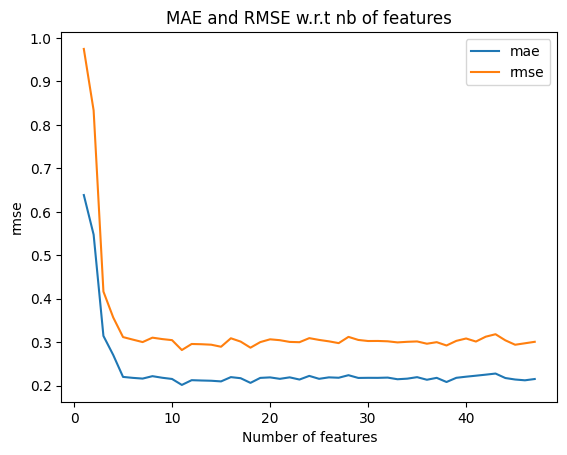

In [59]:
def show_chart(df,metric):
    temp_1 = df[metric].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel(metric)
    plt.title('MAE and RMSE w.r.t nb of features')
    plt.plot(temp_2, temp_1, label=metric)
    plt.savefig('xgboost-accuracy.png')
    plt.legend()

show_chart(measures_df,'mae')
show_chart(measures_df,'rmse')

##**Method 4: RFECV** (not shap related)

* ShapRFECV not supported for regression

In [74]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

In [ ]:
model = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)
rfecv = RFECV(estimator=model)

pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

print(selected_features)
train_selected_features(selected_features,f'RFECV')


In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
rfecv.cv_results_

###**SHAPRFECV** ValueError: continuous format is not supported


In [ ]:
!pip install probatus
from probatus.feature_elimination import ShapRFECV


In [ ]:
shap_elimination = ShapRFECV(
    clf=xgb, step=0.2, cv=5,  n_jobs=3)
report = shap_elimination.fit_compute(X_train, y_train)
# Make plots
performance_plot = shap_elimination.plot()

# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=3)

##**Method 5: Powershap**

In [ ]:
! pip install powershap
# please, use agnostic = True to use with any model...
# agnostic = False will only work with tree-based models

In [79]:
from powershap import PowerShap
xgb_reg = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)

selector = PowerShap(
    model = xgb_reg,
    automatic=True, limit_automatic=100)
selector.fit(X_train, y_train)

selected_features = selector.transform(X_train).columns
train_selected_features(selected_features,f'PowerShap')
selector._processed_shaps_df

  0%|          | 0/10 [00:00<?, ?it/s]

[21:22:18] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:22:48] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:23:04] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:23:16] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:23:28] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:23:41] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:23:53] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:24:07] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:24:20] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[21:24:33] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



,impact,p_value,effect_size,power_0.01_alpha,0.99_power_its_req
Lightpath Lengths,3.559900,0.0,-53.854748,1.000000,2.019898
Modulation Format Level,1.422726,0.0,-30.077788,1.000000,2.209892
Max Spans Lengths,0.542179,0.0,-29.285170,1.000000,2.220330
Mean Spans Lengths,0.230237,0.0,-27.590944,1.000000,2.244284
STD Spans Lengths,0.160745,0.0,-41.153497,1.000000,2.099580
Max Links Lengths,0.093755,0.0,-4.537892,1.000000,4.067819
Mean Links Lengths,0.061939,0.0,-11.530025,1.000000,2.747615
Ligthpath Total Traffic Load,0.022515,0.1,0.000000,0.000000,0.000000
Min Spans Lengths,0.018976,0.0,-1.946467,0.997497,8.744421
Mean Right Hand Links Traffic Load,0.017314,0.4,0.000000,0.000000,0.000000


#**Results and Selected Features**

In [90]:
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB after tuning,0.307000,0.224000,0.997000,47,8.024816,0.585000,28.939000,0.399000
1,Feature Selection method: PowerShap,0.308000,0.221000,0.997000,8,2.043260,0.446000,8.089000,0.388000
2,Feature Selection method: Boruta,0.307000,0.218000,0.997000,12,2.769405,0.582000,28.985000,0.396000
3,Feature Selection method: RFE,0.297000,0.214000,0.998000,10,2.414373,0.587000,33.825000,0.400000
4,Feature Selection method: RFA,0.289000,0.210000,0.998000,31,5.079741,0.590000,27.410000,0.404000
5,Another RFA Approach,0.281846,0.201531,0.997935,11,3.794236,0.446353,6.057024,0.392675
6,Feature Selection method: Top K=11,0.292000,0.213000,0.998000,11,3.910816,0.450000,7.307000,0.397000
7,Feature Selection method: RFECV,0.295000,0.213000,0.998000,11,2.353807,0.580000,27.959000,0.389000


In [91]:
get_features()

,Feature_Selection_Method,Nb_Features,Selected_Features
0,PowerShap,8,"Modulation Format Level, Mean Spans Lengths, M..."
1,Boruta,12,"Modulation Format Level, Mean Spans Lengths, M..."
2,RFE,10,"Modulation Format Level, Mean Spans Lengths, M..."
3,RFA,31,"Modulation Format Level, Link Number, Mean Spa..."
4,Top K=11,11,"Root Mean Square Link Powers, Min Spans Length..."
5,RFECV,11,"Modulation Format Level, Mean Spans Lengths, M..."
6,Another RFA Approach,10,"Lightpath Lengths, Modulation Format Level, Ma..."
